Etape 1 : importer les librairies necessaires

In [19]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pathlib
from pathlib import Path
import os

import imghdr
from PIL import Image
import cv2 

import itertools
import datetime

Etape 2 : Préparer l'envirronement de travail

In [20]:
# Use Python version : 3.8.8
# Use Tensorflow version : < 2.11.0
print("Tensorflow version : ", tf.__version__)

Tensorflow version :  2.10.1


In [21]:
def prepare_gpu_acceleration():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print("GPU is AVAILABLE 🚀")
        print(tf.config.experimental.list_physical_devices('GPU'))
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print("An error occured while setting memory growth for GPU 💀")
            print(e)
    else:
        print("GPU is NOT AVAILABLE 🐌")
        print(tf.config.experimental.list_physical_devices())

prepare_gpu_acceleration()

GPU is AVAILABLE 🚀
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Etape 3 : Préparer les données d'entrainement de validation et de test

In [22]:
#definir le chemin vers le répertoire recine du dataset
data_dir = "data"
data_set = pathlib.Path(data_dir)

In [23]:
# Identifier le nombre de fichier dans le dataset
def file_counter():
    counter = {}
    for subdir, dirs, files in os.walk(data_dir):
        # si le repertoire est un répertoire de classe contient des images
        if len(files) > 0:
            # récuperer le nom de la classe
            class_name = os.path.basename(subdir)
            # compter le nombre d'images dans le dictionnaire
            count = len(files)
            # enregistrer le nombre d'images dans le dictionnaire
            counter[class_name] = count

    return counter


counter = file_counter()

print("Nombre de fichiers dans le dataset : ", len(list(data_set.glob('*/*'))))
for class_name, count in counter.items():
    print(f"{class_name} : {count}")


Nombre de fichiers dans le dataset :  19986
Painting : 9993
Photo : 9993


In [24]:
# filtrer le dataset , deplacer les images corrumpu

accepted_extensions = [".png", ".jpg", ".jpeg", ".bmp"]

corrupted_images_dir = "corrupted"

# filtrer le dataset , deplacer les images corrumpu
def move_invalid_files(file, subdir):
    if not os.path.exists(corrupted_images_dir):
        os.mkdir(corrupted_images_dir)
    invalid_image_path = os.path.join(corrupted_images_dir, file)
    os.rename(os.path.join(subdir, file), invalid_image_path)


def check_images():
    valid_count = 0
    invalid_count = 0
    count_by_class = {}
    for subdir, dirs, files in os.walk(data_dir):
        # si le repertoire est un répertoire de classe contient des images
        if len(files) > 0:
            for file in files:
                # récuperer le nom de la classe
                class_name = os.path.basename(subdir)
                if class_name not in count_by_class:
                    count_by_class[class_name] = {"valid": 0, "invalid": 0}
                # vérifier si l'extension du fichier est accepté
                if Path(file).suffix.lower() in accepted_extensions:
                    # vérifier si le fichier est une image valide
                    if imghdr.what(os.path.join(subdir, file)) is not None:
                        # check si les images ne sont pas corrompues
                        try:
                            img_bytes = tf.io.read_file(os.path.join(subdir, file))
                            decoded_img = tf.image.decode_image(img_bytes)
                            valid_count += 1
                            count_by_class[class_name]["valid"] += 1
                        except tf.errors.InvalidArgumentError as e:
                            invalid_count += 1
                            count_by_class[class_name]["invalid"] += 1
                            move_invalid_files(file, subdir)
                    else:
                        invalid_count += 1
                        count_by_class[class_name]["invalid"] += 1
                        move_invalid_files(file, subdir)
                else:
                    invalid_count += 1
                    count_by_class[class_name]["invalid"] += 1
                    move_invalid_files(file, subdir)
    return valid_count, invalid_count, count_by_class


# valid_count, invalid_count, count_by_class = check_images()
# print("🟢 valid images: ", valid_count)
# print("🔴 invalid count: ", invalid_count)
# for class_name, count in count_by_class.items():
#     print(class_name)
#     print(f"- {count['valid']} valid")
#     print(f"- {count['invalid']} invalid")


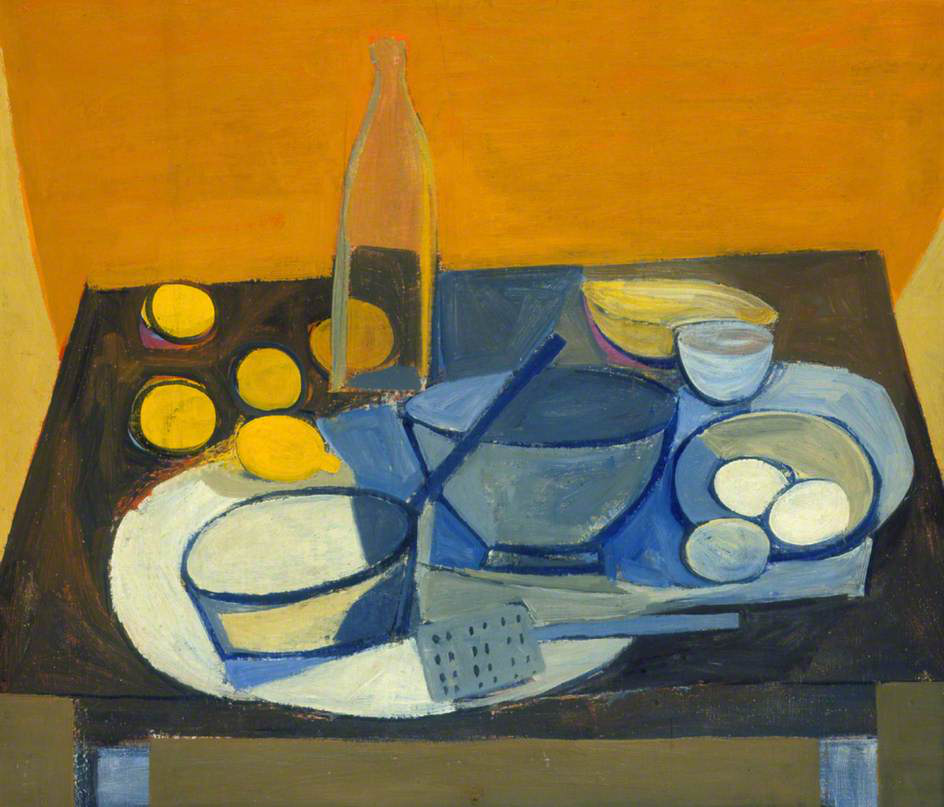

In [25]:
#afficher un echantillons du dataset
painting_images = list(data_set.glob('Painting/*'))
random_painting = np.random.choice(painting_images, 1)
Image.open(str(random_painting[0]))


In [26]:
BATCH_SIZE = 32
IMG_H = 128
IMG_W = 128
SEEDS = 123
VALIDATION_SPLIT = 0.2

In [27]:
# preparer le dataset
 
train_set = tf.keras.utils.image_dataset_from_directory(
    data_set,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEEDS,
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_set,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEEDS,
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 19986 files belonging to 2 classes.
Using 15989 files for training.
Found 19986 files belonging to 2 classes.
Using 3997 files for validation.


In [28]:
val_batches = tf.data.experimental.cardinality(val_set)
test_set = val_set.take(val_batches // 5)
val_set = val_set.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of validation batches: 100
Number of test batches: 25


In [29]:
# récupérer les noms des classes du dataset
class_names = train_set.class_names
print(f"🎭 Categories : {class_names}")

🎭 Categories : ['Painting', 'Photo']


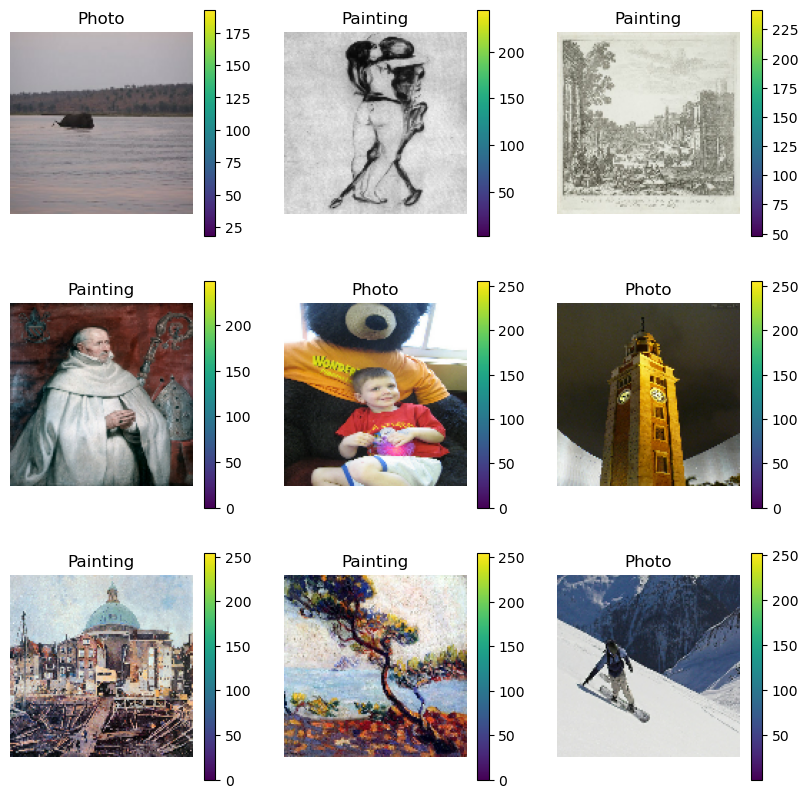

In [30]:
# afficher un echantillon du dataset
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.colorbar()
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [31]:
print(type(train_set))
images , labels = iter(train_set).next()
print(f"🖼️ images shape : {images.shape}")
print(f"🎟️ labels shape{labels.shape}")

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
🖼️ images shape : (32, 128, 128, 3)
🎟️ labels shape(32,)


In [32]:
image_batch , label_batch = next(iter(train_set))
print(f"🔼 image min : {image_batch.numpy().min()}")
print(f"🔽 image max : {image_batch.numpy().max()}")

🔼 image min : 0.0
🔽 image max : 255.0


In [33]:
NUM_CLASSES = len(class_names)
NO_EPOCHS = 10
SHUFFLE = 1000
RESCALING = 1./255
RANDOM_ROTATION = 0.1
RANDOM_ZOOM = 0.1
RANDOM_FILP = "horizontal_and_vertical"

In [34]:
# cache conserve les images en mémoire après leur chargement hors disque au cours de la première Epoch
# prefetch chevauche le prétraitement des données et l'exécution du modèle pendant la formation.
# eviter overfitting et augmenter la vitesse d'entrainement du modele
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().shuffle(SHUFFLE).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)


In [35]:
# creation du model
model = tf.keras.models.Sequential([
    # Couche de normalisation
    tf.keras.layers.Rescaling(RESCALING, input_shape=(IMG_H, IMG_W, 3)),

    # data augmentation
    tf.keras.layers.RandomFlip(RANDOM_FILP),
    tf.keras.layers.RandomRotation(RANDOM_ROTATION),
    tf.keras.layers.RandomZoom(RANDOM_ZOOM),

    # couche de convolution
    # couche de convolution
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    # couche de convolution
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),  # couche de pooling
    tf.keras.layers.Conv2D(128, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.Conv2D(128, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.MaxPooling2D(),  # couche de pooling
    tf.keras.layers.Conv2D(256, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.Conv2D(256, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.Conv2D(256, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.MaxPooling2D(),  # couche de pooling
    tf.keras.layers.Conv2D(512, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.Conv2D(512, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.Conv2D(512, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.MaxPooling2D(),  # couche de pooling
    tf.keras.layers.Conv2D(512, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.Conv2D(512, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.Conv2D(512, 3, padding="same",
                           activation="relu"),  # couche de convolution
    tf.keras.layers.MaxPooling2D(),  # couche de pooling

    # couche de flattening
    tf.keras.layers.Flatten(),  # couche de flatteningù

    # couche de sortie
    tf.keras.layers.Dense(4096, activation="relu"),  # couche de sortie
    tf.keras.layers.Dropout(0.25),  # couche de dropout
    tf.keras.layers.Dense(4096, activation="relu"),  # couche de sortie
    tf.keras.layers.Dropout(0.25),  # couche de dropout
    tf.keras.layers.Dense(
        NUM_CLASSES, activation="softmax")  # couche de sortie
])


In [36]:
# compiler le model optimizer=keras.optimizers.Adam(learning_rate=0.00015)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'])


In [37]:
# resumer du model
# model.build(input_shape=images.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                        

In [38]:
# Definition de la validation croisée
models_dir = 'models/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/' + 'model.h5'
logs_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [39]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logs_dir , histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(models_dir, verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto') , 
]

In [24]:
hist = model.fit(
    train_set,
    validation_data=val_set,
    epochs=NO_EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.6852
Epoch 1: val_loss improved from inf to 0.62287, saving model to models/20221228-011640\model_CNN_photos_painting.h5
500/500 [==============================] - 154s 226ms/step - loss: 0.5999 - accuracy: 0.6852 - val_loss: 0.6229 - val_accuracy: 0.6920
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7714
Epoch 2: val_loss improved from 0.62287 to 0.60538, saving model to models/20221228-011640\model_CNN_photos_painting.h5
500/500 [==============================] - 106s 211ms/step - loss: 0.4927 - accuracy: 0.7714 - val_loss: 0.6054 - val_accuracy: 0.7285
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.4381 - accuracy: 0.8055
Epoch 3: val_loss improved from 0.60538 to 0.56613, saving model to models/20221228-011640\model_CNN_photos_painting.h5
500/500 [==============================] - 105s 210ms/step - loss: 0.4381 - accuracy: 

In [25]:
loss, acc = model.evaluate(val_set, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

125/125 [==============================] - 1s 6ms/step - loss: 0.5588 - accuracy: 0.7796
Test loss: 0.5588293075561523
Test accuracy: 0.7795847058296204


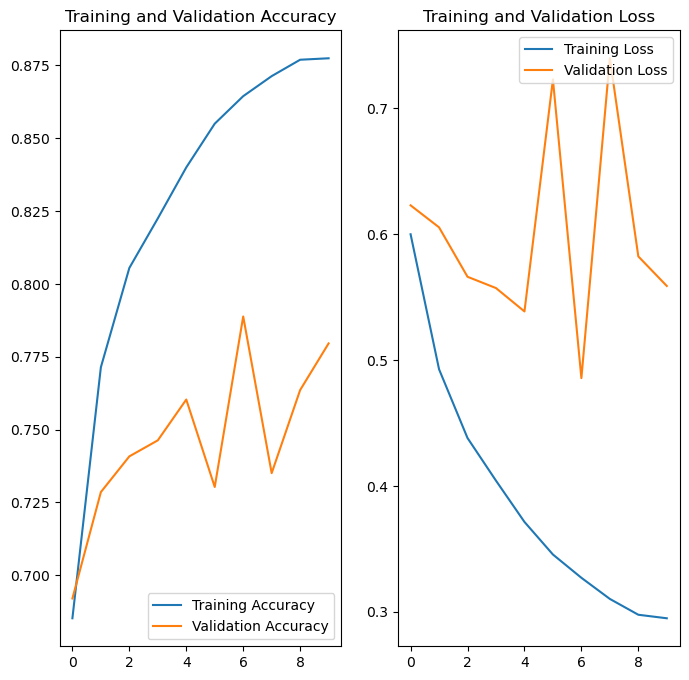

In [26]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [27]:
def overfitting_underfitting(acc , val_acc , loss , val_loss):
   if acc[-1] > val_acc[-1] and loss[-1] < val_loss[-1]:
      print("The model is overfitting 🤮")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
   elif acc[-1] < val_acc[-1] and loss[-1] > val_loss[-1]: 
      print("The model is underfitting 🗿")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
   else:
      print("The model is perfect fit 🧠")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
overfitting_underfitting(acc , val_acc , loss , val_loss)

The model is overfitting 🤮
Training accuracy : 87.75%
Validation accuracy : 77.96%
